<a href="https://colab.research.google.com/github/Aesol-Ahn/DA_Exercise/blob/master/1126%EC%98%81%ED%99%94%EB%A6%AC%EB%B7%B0%EA%B0%90%EC%84%B1%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#영화 리뷰 감성분석

In [3]:
pip install konlpy

     |████████████████████████████████| 19.4MB 20.1MB/s 
     |████████████████████████████████| 92kB 9.1MB/s 
     |████████████████████████████████| 460kB 37.1MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [4]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [5]:
#okt를 쓸 것인데, mecab도 많이 쓴다. 

In [6]:
#데이터셋 다운
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")


('ratings_test.txt', <http.client.HTTPMessage at 0x7f7ab16ec588>)

In [7]:

train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')


In [8]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력


훈련용 리뷰 개수 : 150000


In [9]:
# 상위 5개 출력
train_data[:5] 



,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [10]:
# 테스트용 리뷰 개수 출력
print('테스트용 리뷰 개수 :',len(test_data)) 


테스트용 리뷰 개수 : 50000


In [12]:
train_data['document'].nunique(), train_data['label'].nunique()

#label은 0아니면 1이기 때문에 2가 출력
#중복을 제외한 데이터 길이 146182,2

(146182, 2)

In [13]:
train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(train_data))


총 샘플의 수 : 146183


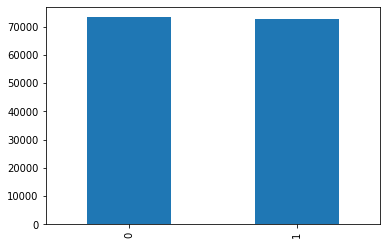

In [14]:
train_data['label'].value_counts().plot(kind = 'bar')

#거의 비슷하게 분포되어 있는 것을 확인할 수 있다.

In [15]:
print(train_data.groupby('label').size().reset_index(name = 'count'))


   label  count
0      0  73342
1      1  72841


In [16]:
#null이 있는지 확인

print(train_data.isnull().values.any())


True


In [17]:
print(train_data.isnull().sum())


id          0
document    1
label       0
dtype: int64


In [18]:
train_data.loc[train_data.document.isnull()]


,id,document,label
25857,2172111,NaN,1


In [19]:
#null 제거

train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인


False


In [20]:
#알파벳과 공백을 제외한 문자 다 제거 하고 싶을 때,

text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'

re.sub('[^a-zA-Z ]', '', text) #알파벳과 공백을 제외하고 모두 제거

#대괄호 안에 ^가 있냐 없느냐에 따라 다르다

'do you expect people to read the FAQ etc and actually accept hard atheism'

In [21]:
#한글과 공백을 제외한 문자 다 제거 하고 싶을 때,

train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [22]:
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())


id            0
document    391
label         0
dtype: int64


In [23]:
train_data.loc[train_data.document.isnull()][:5]

#null에 해당하는 값 확인

,id,document,label
584,7117896,NaN,0
593,6478189,NaN,0
638,9364602,NaN,0
668,1600635,NaN,0
1559,6918082,NaN,1


In [24]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))


145791


In [25]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))


전처리 후 테스트용 샘플의 개수 : 48995
